In [2]:
import sys
print(sys.version)

3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:14:23) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
"""
Created on May 20 2018
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)  

In [4]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [5]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

#Zernike_Module_lastOct15_beforeScatterChange
import Zernike_Module
from Zernike_Module import *

In [7]:
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

# PIPE2D-424

In [145]:
from astropy.io import fits
#000
old_arc_raw=fits.open('/Volumes/My Passport for Mac/Old_Files/PFS/LAM/raw/2019-02-28/PFLA01332512.fits')


old_flat_raw=fits.open('/Volumes/My Passport for Mac/Old_Files/PFS/LAM/raw/2019-02-28/PFLA01318312.fits')



In [146]:
old_flat_raw[0].data.shape

(4300, 4416)

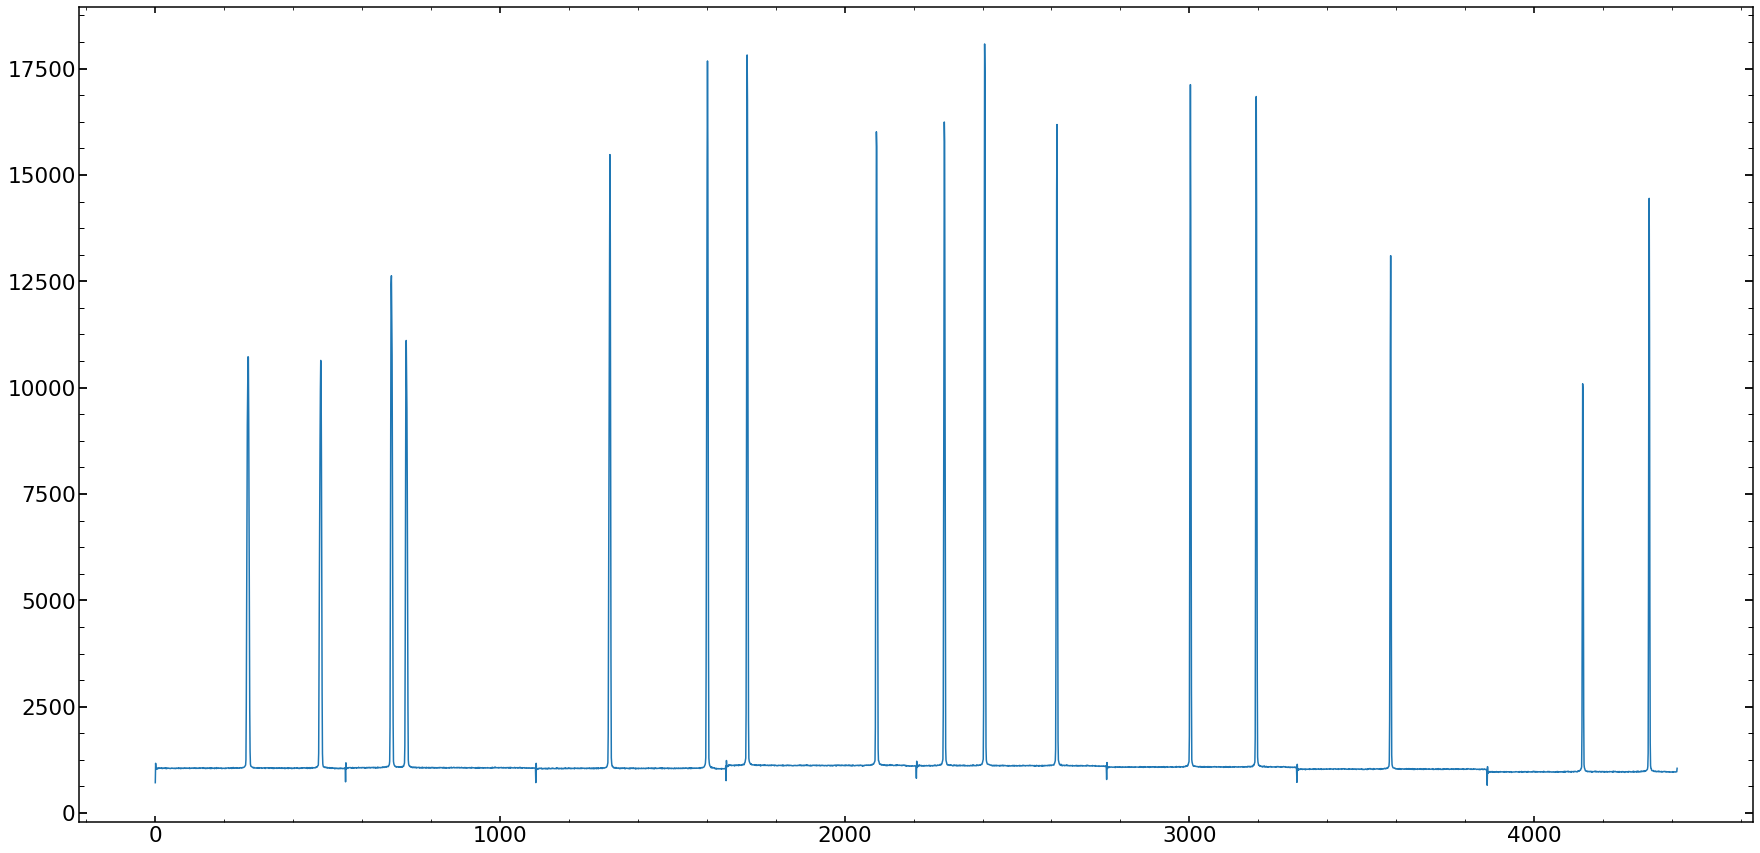

In [147]:
plt.figure(figsize=(30,15))
plt.plot(old_flat_raw[0].data[2150])

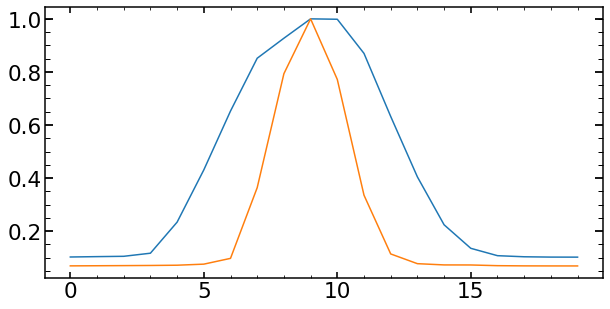

In [148]:
plt.figure(figsize=(10,5))

cut_fiber_0=old_flat_raw[0].data[2150][260:280]
cut_fiber_16=old_flat_raw[0].data[2150][4325:4345]

cut_fiber_0=cut_fiber_0/np.max(cut_fiber_0)
cut_fiber_16=cut_fiber_16/np.max(cut_fiber_16)

plt.plot(cut_fiber_0)
plt.plot(cut_fiber_16)

([<matplotlib.axis.XTick at 0x253bb570b8>,
 <a list of 10 Text xticklabel objects>)

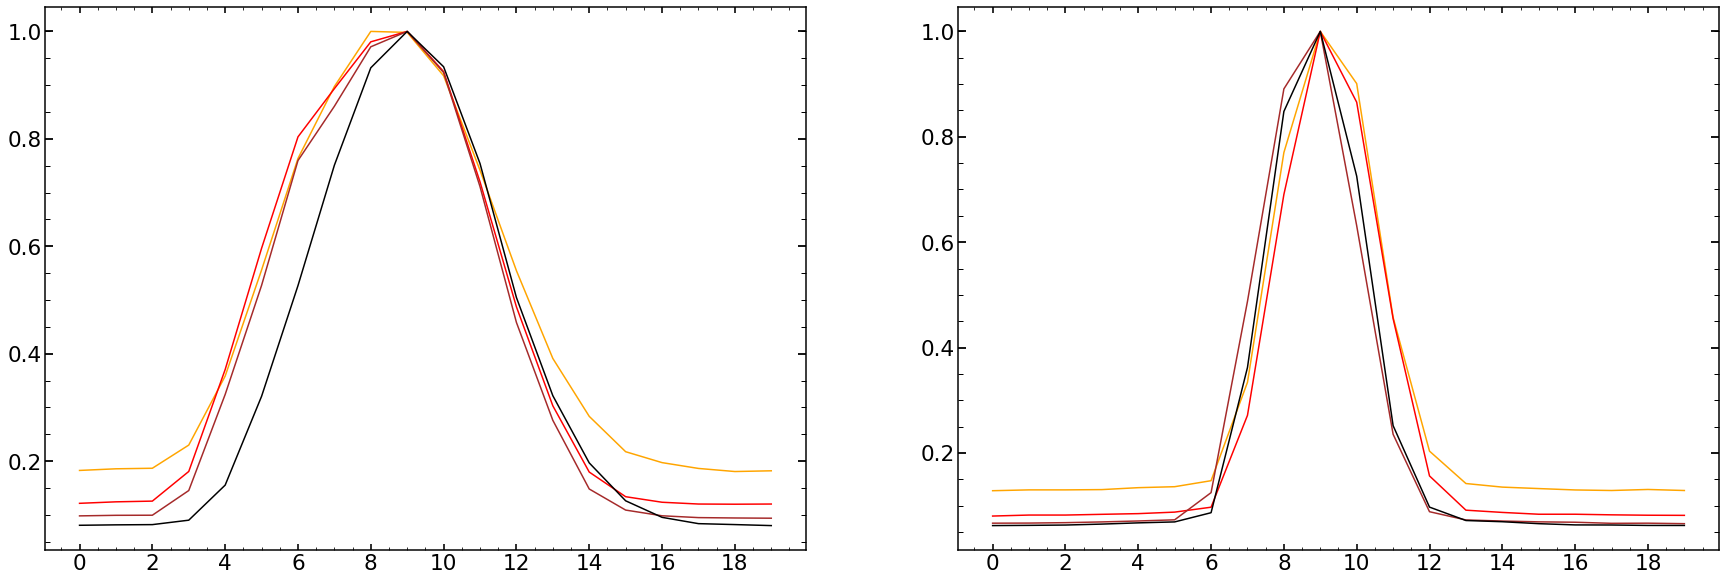

In [149]:
cut_fiber_0_500=old_flat_raw[0].data[500][254:274]
cut_fiber_0_1500=old_flat_raw[0].data[1500][260:280]
cut_fiber_0_2500=old_flat_raw[0].data[2500][260:280]
cut_fiber_0_3500=old_flat_raw[0].data[3500][254:274]

cut_fiber_0_500=cut_fiber_0_500/np.max(cut_fiber_0_500)
cut_fiber_0_1500=cut_fiber_0_1500/np.max(cut_fiber_0_1500)
cut_fiber_0_2500=cut_fiber_0_2500/np.max(cut_fiber_0_2500)
cut_fiber_0_3500=cut_fiber_0_3500/np.max(cut_fiber_0_3500)

cut_fiber_16_500=old_flat_raw[0].data[500][4319:4339]
cut_fiber_16_1500=old_flat_raw[0].data[1500][4324:4344]
cut_fiber_16_2500=old_flat_raw[0].data[2500][4325:4345]
cut_fiber_16_3500=old_flat_raw[0].data[3500][4321:4341]

cut_fiber_16_500=cut_fiber_16_500/np.max(cut_fiber_16_500)
cut_fiber_16_1500=cut_fiber_16_1500/np.max(cut_fiber_16_1500)
cut_fiber_16_2500=cut_fiber_16_2500/np.max(cut_fiber_16_2500)
cut_fiber_16_3500=cut_fiber_16_3500/np.max(cut_fiber_16_3500)

plt.figure(figsize=(30,10))
plt.subplot(121)
plt.plot(cut_fiber_0_500,color='orange')
plt.plot(cut_fiber_0_1500,color='red')
plt.plot(cut_fiber_0_2500,color='brown')
plt.plot(cut_fiber_0_3500,color='black')
plt.xticks(np.arange(0, 20, step=2))

plt.subplot(122)
plt.plot(cut_fiber_16_500,color='orange')
plt.plot(cut_fiber_16_1500,color='red')
plt.plot(cut_fiber_16_2500,color='brown')
plt.plot(cut_fiber_16_3500,color='black')
plt.xticks(np.arange(0, 20, step=2))

([<matplotlib.axis.XTick at 0x253e9fe748>,
 <a list of 10 Text xticklabel objects>)

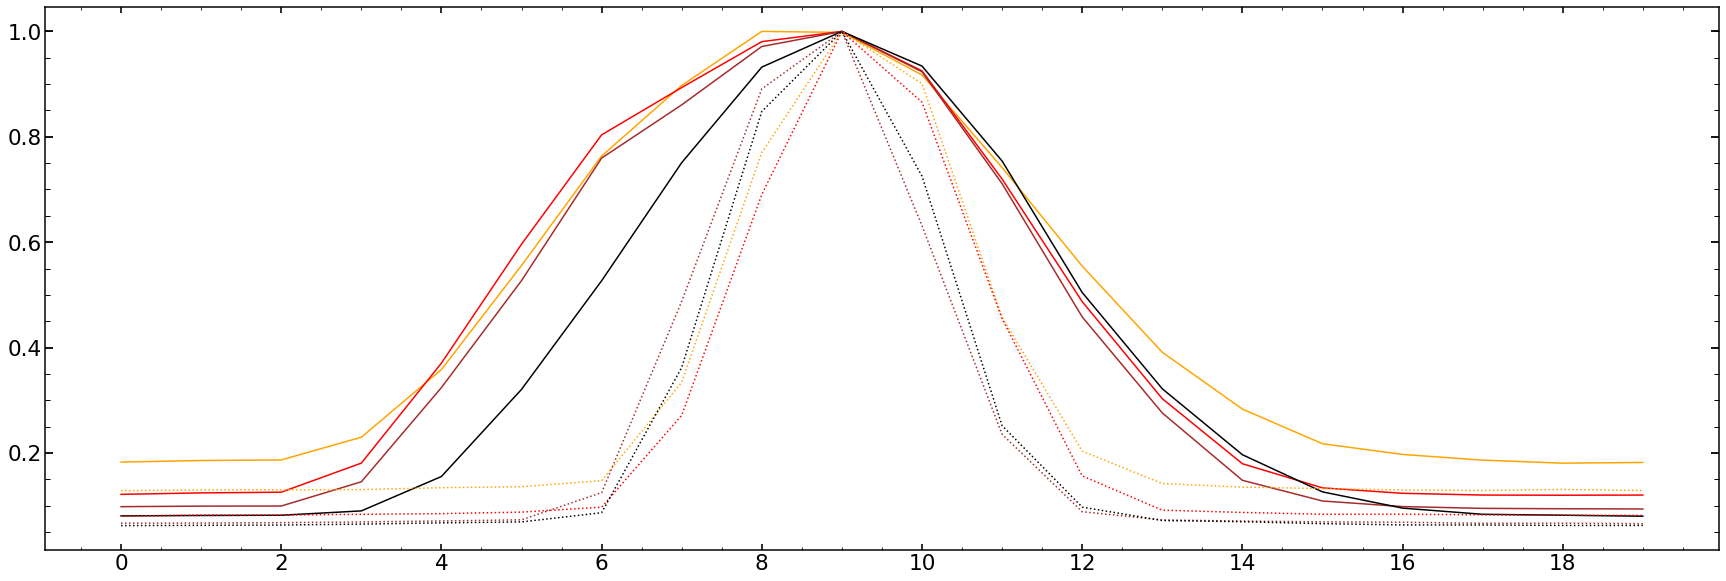

In [150]:
plt.figure(figsize=(30,10))
plt.plot(cut_fiber_0_500,color='orange')
plt.plot(cut_fiber_0_1500,color='red')
plt.plot(cut_fiber_0_2500,color='brown')
plt.plot(cut_fiber_0_3500,color='black')

plt.plot(cut_fiber_16_500,color='orange',ls=':')
plt.plot(cut_fiber_16_1500,color='red',ls=':')
plt.plot(cut_fiber_16_2500,color='brown',ls=':')
plt.plot(cut_fiber_16_3500,color='black',ls=':')

plt.xticks(np.arange(0, 20, step=2))


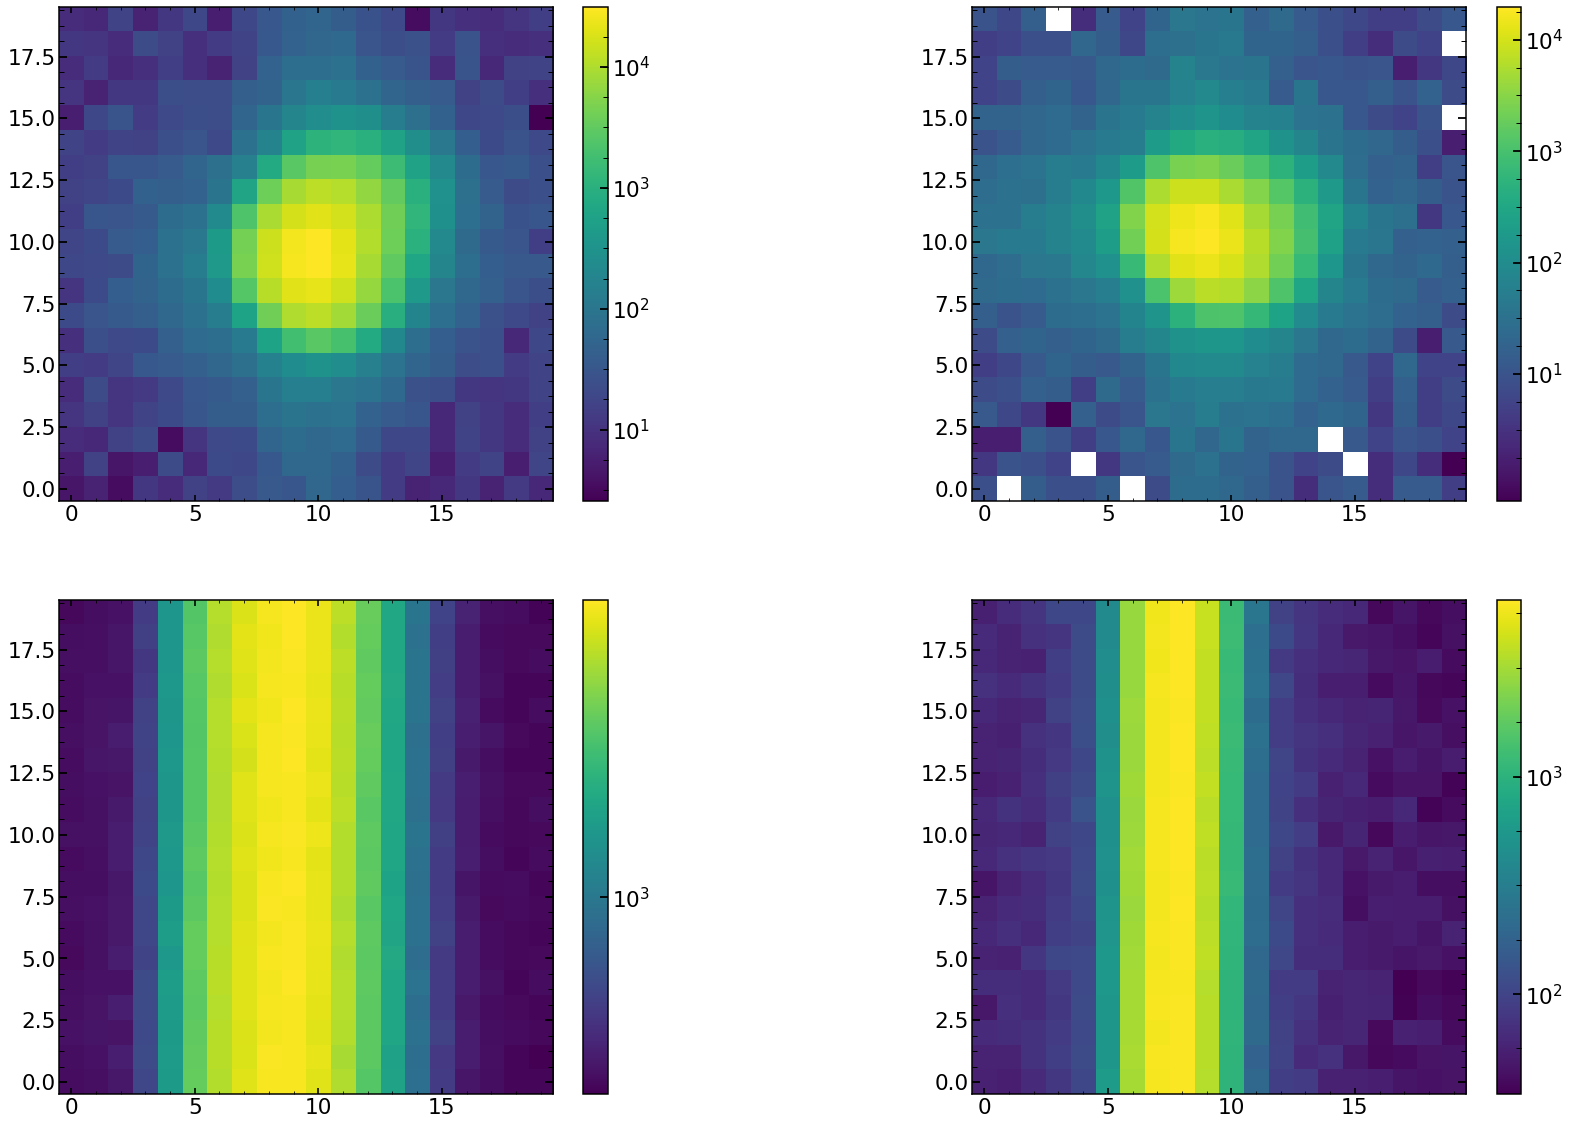

In [151]:
cut_fiber_0_arc=old_arc_raw[0].data[879-10:879+10,267-10:267+10]
cut_fiber_16_arc=old_arc_raw[0].data[878-10:878+10,4140-10:4140+10]

cut_fiber_0_arc=cut_fiber_0_arc-np.median(cut_fiber_0_arc[:,0]*0.99)
cut_fiber_16_arc=cut_fiber_16_arc-np.median(cut_fiber_16_arc[:,0]*0.99)


cut_fiber_0_flat=old_flat_raw[0].data[879-10:879+10,267-10:267+10]
cut_fiber_16_flat=old_flat_raw[0].data[878-10:878+10,4140-10:4140+10]

cut_fiber_0_flat=cut_fiber_0_flat-np.median(cut_fiber_0_flat[:,0]*0.70)
cut_fiber_16_flat=cut_fiber_16_flat-np.median(cut_fiber_16_flat[:,0]*0.94)



plt.figure(figsize=(30,20))
plt.subplot(221)
plt.imshow(cut_fiber_0_arc,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(222)
plt.imshow(cut_fiber_16_arc,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(223)
plt.imshow(cut_fiber_0_flat,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(224)
plt.imshow(cut_fiber_16_flat,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [152]:
cut_fiber_0_arc[:,0]

array([ 4.56,  5.56,  8.56, 10.56,  8.56, 14.56,  9.56, 21.56, 10.56,
       19.56, 18.56, 14.56, 16.56, 14.56, 17.56,  5.56, 10.56,  8.56,
       11.56,  8.56])

In [153]:
cut_fiber_0=old_arc_raw[0].data[997-10:997+10,269-10:269+10]
cut_fiber_0[10]

array([ 1180,  1254,  1317,  1464,  1785,  6046, 39902, 65535, 65535,
       65535, 65535, 65535, 63512, 24172,  1794,  1396,  1231,  1207,
        1176,  1155], dtype=uint16)

In [154]:
def create_only_trace(best_img,norm_of_trace,norm_of_serial_trace):
    if norm_of_trace==0:
        return best_img
    else:
        data_shifted_left_right=np.zeros(np.shape(best_img))
        data_shifted_left_right[:, :] =np.sum(best_img,axis=0)*norm_of_trace
    
        data_shifted_up_down=np.transpose(np.zeros(np.shape(best_img)))         
        data_shifted_up_down[:, :] =np.sum(best_img,axis=1)*norm_of_serial_trace
        data_shifted_up_down=np.transpose(data_shifted_up_down)
    
        return data_shifted_up_down+data_shifted_left_right   

IndexError: too many indices for array

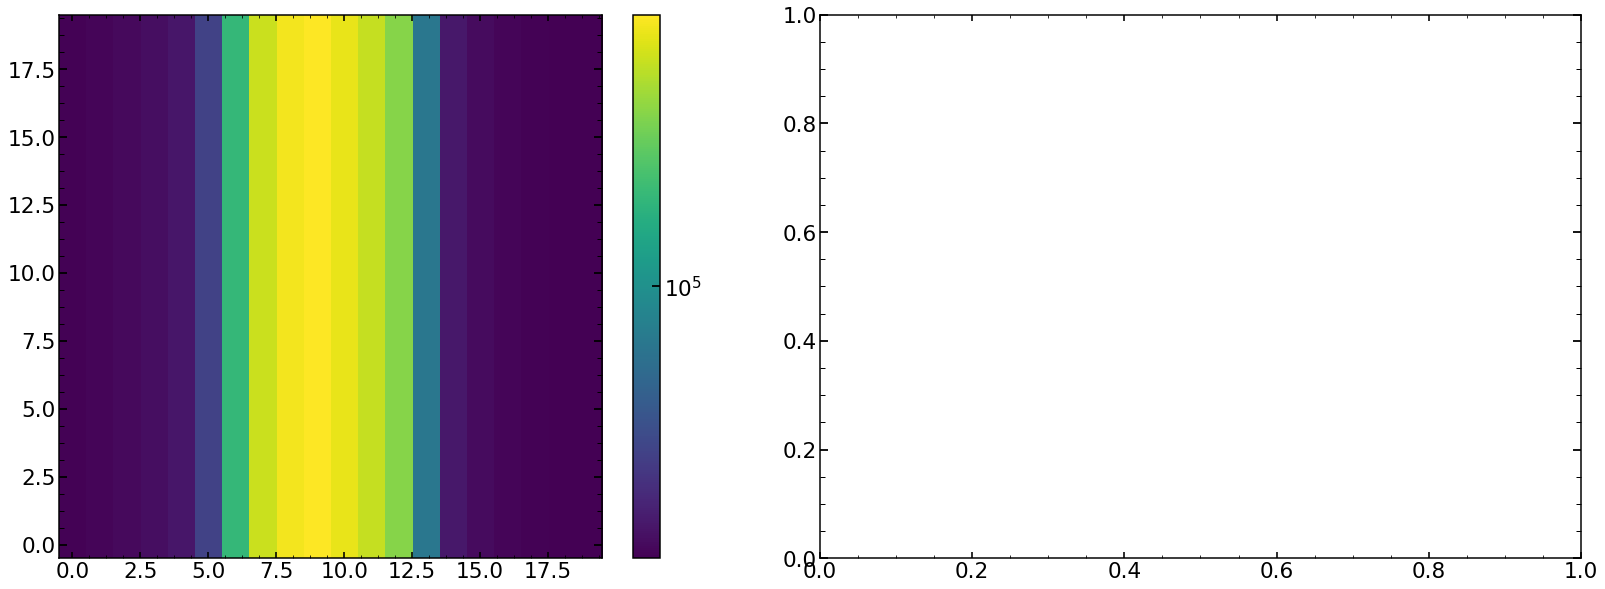

In [155]:
plt.figure(figsize=(30,10))
plt.subplot(121)
fake_trace_0_created_from_arcs=create_only_trace(cut_fiber_0,1,0)
plt.imshow(fake_trace_0_created_from_arcs,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(122)
fake_trace_16_created_from_arcs=create_only_trace(cut_fiber_16,1,0)
plt.imshow(fake_trace_16_created_from_arcs,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

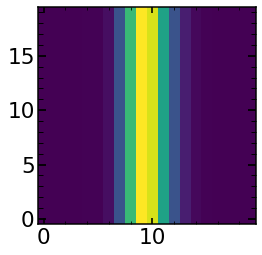

In [114]:
plt.imshow(create_only_trace(cut_fiber_0,1,0))